In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap
from functools import reduce
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.decomposition import PCA

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    divide_into_lds,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot, plot_training_history
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss, AE, decoder, create_meta_decoder_n

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters, concat_dims_one_hot, concat_dims

2025-04-01 10:09:54.568830: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 10:09:54.681345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 10:09:55.699691: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 10:09:55.704534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 10:09:57.951971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [18]:
# # Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# # with the CHROM:POS for every corresponding RSID

# # GTM data

# path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
# path_raw = f"{CONFIG['PATH_data']}/01_raw/"
# path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

# geno = make_df(path_data_raw, path_usefull, path_raw)

# afs = calculate_AFs(geno)

# path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
# merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)

# # Divide the AFs into chunks

# size_chunck = 20_000
# min_maf = 0.01

# path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
# path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
# path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

# divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)


In [19]:

# # From AF_Chunks to PCA representation

# path_chunks = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"

# nr_projected_dims = 3
# nr_snps_for_PCA_per_chrom = 200
# os.listdir(path_chunks)
# chroms = [f for f in os.listdir(path_chunks) if f.startswith("chrom")]
# for chrom in chroms:
#     path_chrom = f"{path_chunks}{chrom}/"
#     chunks = [f for f in os.listdir(path_chrom) if f.startswith("chunk")]
#     for chunk in chunks:
#         path_chunk = f"{path_chrom}/{chunk}"
        
#         path_to_do = f"{path_projected_snps}/to_do/{chrom}/"
#         os.makedirs(path_to_do, exist_ok=True)
#         os.system(f"cp {path_chunk} {path_to_do}")
    

# path_to_do = f"{path_projected_snps}/to_do/"
# for i in list(range(nr_projected_dims)):
#     path_projected = f"{path_projected_snps}/projection_{i}/"
#     os.makedirs(path_projected, exist_ok=True)
#     genos = []
#     for chrom in chroms:
#         path_chrom = f"{path_projected_snps}/to_do/{chrom}/"
#         chunks = os.listdir(path_chrom)
#         nr_snps_for_PCA_per_chunks = math.ceil(nr_snps_for_PCA_per_chrom / len(chunks))
#         for chunk in chunks:
#             path_chunk = f"{path_chrom}/{chunk}"
#             geno = pd.read_pickle(path_chunk)
#             num_available_columns = geno.shape[1]

#             # Adjust n if needed
#             n = min(nr_snps_for_PCA_per_chunks, num_available_columns)
#             geno = geno.sample(n=n, axis=1)
#             genos.append(geno)
#     genos = pd.concat(genos, axis=1)
#     # Standardize the data (zero mean, unit variance)
#     scaler = StandardScaler()
#     genos = scaler.fit_transform(genos)  # Returns a NumPy array

#     # Apply PCA
#     pca = PCA(n_components=1)
#     genos_pca = pca.fit_transform(genos)

#     # Convert PCA output to DataFrame
#     genos_pca = pd.DataFrame(genos_pca, columns=[f'PC1'])
#     genos_pca.to_pickle(f"{path_projected}/PC1_projection_{i}.pkl")
    
#     # Select only the SNPs with low P_vals with the PCA and update the to_do folder
#     chroms = [f for f in os.listdir(path_to_do) if f.startswith('chrom')]
#     for chrom in chroms:
#         path_chrom = f"{path_to_do}/{chrom}"
#         path_projected_chrom = f"{path_projected}/03_macro_similar_AF/{chrom}/"
#         os.makedirs(path_projected_chrom, exist_ok=True)
        
#         chunks = os.listdir(path_chrom)
#         for chunk in chunks:
#             path_chunk = f"{path_chrom}/{chunk}"
#             path_chunk_raw = f"{path_chunks}/{chrom}/{chunk}"
            
#             geno_raw = pd.read_pickle(path_chunk_raw)
#             nr_snps_raw = geno_raw.shape[1]
#             to_take = math.ceil(nr_snps_raw/nr_projected_dims)
#             geno = pd.read_pickle(path_chunk)
            
            
#             p_vals = []
#             betas = []
#             snps = []
            
#             for snp in geno.columns:
#                 y = genos_pca[['PC1']].reset_index(drop=True)
#                 X1 = geno[[snp]].reset_index(drop=True)
#                 [beta_values, p_values] = ols_regression(y['PC1'], X1[snp], covs=None)
#                 p_vals.append(p_values[snp])
#                 betas.append(beta_values[snp])
#                 snps.append(snp)
                
#             p_vals = pd.DataFrame(data = {'pval': p_vals, 'betas':betas, 'snp_rs':snps})
#             p_vals['-logp'] = -np.log10(p_vals['pval'].replace(0, 1e-300))
            
#             # Assuming `p_vals` is a pandas DataFrame
#             to_keep = p_vals.sort_values(by='-logp', ascending=False).head(to_take)
#             to_do = p_vals.loc[~p_vals.index.isin(to_keep.index)]
#             geno[to_keep['snp_rs']].to_pickle(f"{path_projected_chrom}/{chunk}")
#             geno[to_do['snp_rs']].to_pickle(f"{path_to_do}/{chrom}/{chunk}")
# os.system(f"rm -rf {path_to_do}")


In [2]:
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
ids = ids.merge(labels, left_on="IID", right_on="Sample name")

In [21]:

# # Check the population distribution
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# concated_PCs = pd.DataFrame()
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     PC_proj = pd.read_pickle(f"{path_projection}/PC1_projection_{projection_nr}.pkl")
#     concated_PCs[f"dim_{projection_nr+1}"] = PC_proj['PC1']
# concated_PCs['Population name']= list(ids['FID'])
# make_population_plot(concated_PCs, 'dim_1', 'dim_2', 'Population name', f"test", palette = f"rocket")


In [22]:
# # Divide into LD blocks
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# concated_PCs = pd.DataFrame()
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     path_chunks = f"{path_projection}/03_macro_similar_AF/"
#     path_output = f"{path_projection}/04_ld_blocks/"
#     n_components = 10
#     size_block = 1000
#     os.listdir(path_chunks)
#     chroms = [f for f in os.listdir(path_chunks) if f.startswith("chrom")]
#     for chrom in chroms:
#         path_chrom = f"{path_chunks}{chrom}/"
#         path_output_chrom = f"{path_output}{chrom}/"
#         os.makedirs(path_output_chrom, exist_ok=True)
#         chunks = [f for f in os.listdir(path_chrom) if f.startswith("chunk")]
#         for chunk in chunks:
#             name_chunk = chunk.split(".pkl")[0]
#             divide_into_lds(path_chrom, path_output_chrom, name_chunk, n_components, size_block)

# Choose SNPs to project on n dimensions

# Observe raw dimensions

In [23]:
# # Check the population distribution
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# concated_PCs = pd.DataFrame()
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     path_macro_similar = f"{path_projection}/04_ld_blocks/"
#     iterations = 3
#     palette_nr = 0
#     palettes = ['rocket', 'viridis', 'icefire', 'magma', 'plasma', 'inferno', 'cividis', 'twilight', 'twilight_shifted', 'hsv', 'crest', 'brylant', 'vlag', 'deep', 'dense', 'turbo', 'crest', 'delta', 'curl', 'cubehelix', 'phase', 'twilight', 'twilight_shifted', 'hsv', 'icefire', 'crest', 'brylant', 'vlag', 'deep', 'dense', 'turbo', 'crest', 'delta', 'curl', 'cubehelix', 'phase']
#     for iter in list(range(iterations)):
#         iter += 2
#         print(f"Running iteration {iter}")
#         path_output = f"{path_projection}/iteration_{iter}/"
#         if iter == 2:
#             ids[f"cluster_{iter}"] = f"{0}"
#             os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)
#             ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")
            
#         else:
#             pass
        
#         cluster_to_add = []
#         for sub_pop in ids[f"cluster_{iter}"].unique():
#             path_output = f"{path_projection}/iteration_{iter}/pop_{sub_pop}/"
#             os.makedirs(path_output, exist_ok=True)
#             temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
#             nr_of_projected_dimensions = 4
#             geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
            
#             existing_dims = []   
#             for PCs in [f for f in os.listdir(path_output) if f.startswith('PCs')]:
#                 dim = PCs.split('PCs_')[1].split('.pkl')[0]
#                 path_PC = f"{path_output}/{PCs}"
#                 PCs = pd.read_pickle(f"{path_PC}")
#                 temp_ids = temp_ids.copy()
#                 temp_ids[dim] = list(PCs['PC1'])
#                 existing_dims.append(dim)
#             labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
#             for element in labels:
#                 cluster_to_add.append(f"{sub_pop}_{element}")
                
#         ids[f"cluster_{iter+1}"] = cluster_to_add
#         ids.to_pickle(f"{path_projection}/iteration_{iter}/ids.pkl")
        
#         # Vizualization
#         path_input = f"{path_projection}/iteration_{iter}/"
#         for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
#             pop = pop.split('pop_')[1]
#             temp_ids = ids[ids[f"cluster_{iter}"] == pop]
#             path_pop = f"{path_input}/pop_{pop}"
#             for PCs in [f for f in os.listdir(path_pop) if f.startswith('PCs')]:
#                 dim = PCs.split('PCs_')[1].split('.pkl')[0]
#                 path_PC = f"{path_pop}/{PCs}"
#                 PCs = pd.read_pickle(f"{path_PC}")
#                 temp_ids = temp_ids.copy()
#                 temp_ids[dim] = list(PCs['PC1'])
#             if len(list(temp_ids['Population name'].unique())) > 20:
#                 make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Superpopulation name', f"iteration {iter} - pop {pop}", palette = f"{palettes[palette_nr]}")
#             else:
#                 make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Population name', f"iteration {iter} - pop {pop}", palette = f"{palettes[palette_nr]}")
#         palette_nr += 1

# Find the dims per snp

In [24]:

# # Every dimensions is explained by certain snps, we want to know which snps are the most important for each dimension

# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# concated_PCs = pd.DataFrame()
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
    
#     iteration_files = [f for f in os.listdir(path_projection) if f.startswith('iteration')]
#     snp_ids_dfs = []
#     for iteration in iteration_files:
#         path_iteration = f"{path_projection}/{iteration}/"
#         for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
#             pop = pop.split('pop_')[1]
#             path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"
#             snp_ids = pd.read_pickle(path_snp_ids)
#             snp_ids = snp_ids.drop(columns=['pval', 'betas', '-logp'])
#             snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids['dim'])
#             snp_ids = snp_ids.drop(columns=['dim'])
#             snp_ids = snp_ids.sort_index()  # Now sort
#             snp_ids_dfs.append(snp_ids)
            
#     snp_ids = reduce(lambda left, right: pd.merge(left, right, on='snp_rs'), snp_ids_dfs)
#     snp_ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/projection_{projection_nr}_post_iterations_snp_ids.pkl")

# Use lower dimensional representation to create AF probabilities

In [25]:
# # make for every dims a concatenated dataframe so we have a df with all the dims for every pop, sort of one hot encoded
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# temp_ids = ids.copy()
# concated_PCs = pd.DataFrame()
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     # Making the parent projection (PC1) the projection of iteration 1
#     path_PC1 = f"{path_projection}/iteration_1/pop_0/"
#     os.makedirs(path_PC1, exist_ok=True)
#     temp_ids['cluster_1'] = '0'
#     temp_ids.to_pickle(f"{path_projection}/iteration_1/ids.pkl")
#     os.system(f"cp {path_projection}/PC1_projection_{projection_nr}.pkl {path_PC1}/PCs_dim_1.pkl")
    
#     concat_dims_one_hot(path_projection, 3)

# Create Meta decoder

In [26]:
# # create a meta decoder combining all the decoders

# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"

#     nr_hidden_layer = 2

#     iterations = [f for f in os.listdir(f"{path_projection}") if f.startswith('iteration')]
#     iterations.sort()
#     for iteration in iterations:
#         path_iteration = f"{path_projection}/{iteration}"
#         iteration_nr = int(iteration.split('_')[1])
#         print(f"Running iteration {iteration_nr}")
#         path_iteration = f"{path_projection}/{iteration}/"
#         decoders = []
        
#         for i in range(iteration_nr):
#             i += 1
#             if i == iteration_nr:
#                 pass
#             else:
#                 dim1 = pd.read_pickle(f"{path_projection}/{iterations[i-1]}/concated_one_hot_dims.pkl")
#                 dim2 = pd.read_pickle(f"{path_projection}/{iterations[i]}/concated_one_hot_dims.pkl")
#                 decoder_temp, decoder_history =  decoder(dim1, dim2, nr_hidden_layer, 100, 10)
#                 decoders.append(decoder_temp)
#         if iteration_nr == 1:
#             pass
#         else:
#             meta_iter = create_meta_decoder_n(decoders)
            
            
#             # Ensure all layers are trainable (for fine-tuning)
#             for layer in meta_iter.layers:
#                 layer.trainable = True
#             # Compile the meta-decoder
#             meta_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#             meta_iter.save(f"{path_iteration}/meta_decoder.keras")


In [3]:
from keras.callbacks import EarlyStopping
from keras import backend as K
import gc

def create_one_hot_mafs(df, central, dim, to_keep, meta):
    # Create a minor allele frequency (MAF) mask
    db_minor = df.copy()
    db_minor = db_minor.applymap(lambda x: 1 if x == to_keep else 0)
    decoder_temp, decoder_history =  decoder(dim, db_minor, 2, 100, 10)
    chunk_decoder = create_meta_decoder_n([meta, decoder_temp])
    
    # Ensure all layers are trainable
    for layer in chunk_decoder.layers:
        layer.trainable = True

    # Compile the meta-decoder
    chunk_decoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    history = chunk_decoder.fit(
        central.to_numpy(), 
        db_minor.to_numpy(), 
        epochs=200, 
        validation_split=0.2, 
        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
        verbose=0)
    

    AFs = chunk_decoder.predict(central.to_numpy(), verbose = 0)
    AFs = pd.DataFrame(AFs, columns=df.columns)
    
    K.clear_session()  # Clears the current Keras session
    del chunk_decoder  # Deletes the model object
    gc.collect()  # Forces garbage collection
    return AFs

In [28]:
# # create MAF estimation for first iteration

# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# for projection in projections:
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     central_dim = pd.read_pickle(f"{path_projection}/iteration_1/pop_0/PCs_dim_1.pkl")
#     chroms = [f for f in os.listdir(f"{path_projection}/04_ld_blocks") if f.startswith('chrom')]
#     for chrom in chroms:
#         path_chrom = f"{path_projection}/04_ld_blocks/{chrom}"
#         path_output_chrom = f"{path_projection}/iteration_1/05_macro_estimated_AF/{chrom}"
#         chunks = [f for f in os.listdir(path_chrom) if f.startswith('block')]
#         for chunk in chunks:
#             path_chunk = f"{path_chrom}/{chunk}"
#             chunk_df = pd.read_pickle(path_chunk)
            
#             db_minor = chunk_df.copy()
#             db_minor = db_minor.applymap(lambda x: 1 if x == -1 else 0)
#             decoder_temp, decoder_history =  decoder(central_dim, db_minor, 1, 100, 10)
#             AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
#             AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
#             path_min_maf = f"{path_output_chrom}/q2/"
#             os.makedirs(path_min_maf, exist_ok=True)
            
#             AFs.to_pickle(f"{path_min_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
            
#             db_het = chunk_df.copy()
#             db_het = db_het.applymap(lambda x: 1 if x == 0 else 0)
#             decoder_temp, decoder_history =  decoder(central_dim, db_het, 1, 100, 10)
#             AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
#             AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
#             path_het_maf = f"{path_output_chrom}/2pq/"
#             os.makedirs(path_het_maf, exist_ok=True)
            
#             AFs.to_pickle(f"{path_het_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
            
#             db_maj = chunk_df.copy()
#             db_maj = db_maj.applymap(lambda x: 1 if x == 1 else 0)
#             decoder_temp, decoder_history =  decoder(central_dim, db_maj, 1, 100, 10)
#             AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
#             AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
#             path_maj_maf = f"{path_output_chrom}/p2/"
#             os.makedirs(path_maj_maf, exist_ok=True)
            
#             AFs.to_pickle(f"{path_maj_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
            

In [29]:
# path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
# projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
# for projection in projections:
#     print(f"Running projection {projection}")
#     projection_nr = int(projection.split("_")[-1])
#     path_projection = f"{path_projected_snps}/{projection}/"
#     central_dim  = pd.read_pickle(f"{path_projection}/iteration_1/concated_one_hot_dims.pkl")
    
#     iterations = [f for f in os.listdir(f"{path_projection}") if f.startswith('iteration')]
#     iterations.sort()
#     for iteration in iterations[1:]:
#         print(iteration)
#         iteration_nr = int(iteration.split('_')[1])
        
#         if iteration_nr == 1:
#             pass
#         else:
#             path_iteration = f"{path_projection}/{iteration}"
#             meta_past_iter = load_model(f"{path_iteration}/meta_decoder.keras", compile=False)
#             meta_past_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

#             print(f"Running iteration {iteration_nr} of projection {projection_nr}")
            

#             dim = pd.read_pickle(f"{path_iteration}/concated_one_hot_dims.pkl")
#             # train decoder iteration i with chunk
#             chroms = [f for f in os.listdir(f"{path_projection}/04_ld_blocks") if f.startswith('chrom')]
#             for chrom in chroms:
#                 path_chrom = f"{path_projection}/04_ld_blocks/{chrom}"
#                 path_output_chrom = f"{path_iteration}/05_macro_estimated_AF/{chrom}"
#                 os.makedirs(path_output_chrom, exist_ok=True)
#                 chunks = [f for f in os.listdir(path_chrom) if f.startswith('block')]
#                 for chunk in chunks:
#                     path_chunk = f"{path_chrom}/{chunk}"
#                     chunk_df = pd.read_pickle(path_chunk)
                    
#                     # Create a minor allele frequency (MAF) mask
#                     min_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, -1, meta_past_iter)
#                     path_min_maf = f"{path_output_chrom}/q2/"
#                     os.makedirs(path_min_maf, exist_ok=True)
#                     min_AFs.to_pickle(f"{path_min_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                    
#                     # Create a het allele frequency (MAF) mask
#                     het_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 0, meta_past_iter)
#                     path_het_maf = f"{path_output_chrom}/2pq/"
#                     os.makedirs(path_het_maf, exist_ok=True)
#                     het_AFs.to_pickle(f"{path_het_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                    
#                     # Create a het allele frequency (MAF) mask
#                     maj_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 1, meta_past_iter)
#                     path_maj_maf = f"{path_output_chrom}/p2/"
#                     os.makedirs(path_maj_maf, exist_ok=True)
#                     maj_AFs.to_pickle(f"{path_maj_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")

In [10]:
# Function to compute MAF per population
def calculate_maf(df):
    maf_results = {}

    for pop in df['pop'].unique():
        pop_df = df[df['pop'] == pop]  # Subset by population

        # Count occurrences of each genotype
        count_neg1 = (pop_df['rs6698650_G'] == -1).sum()  # Homozygous minor (-1)
        count_0 = (pop_df['rs6698650_G'] == 0).sum()       # Heterozygous (0)
        total = len(pop_df)  # Total number of individuals

        # Compute MAF
        maf = (count_neg1) / (total)
        maf_results[pop] = maf
    
    return maf_results

In [11]:
import seaborn as sns

Running projection projection_0
iteration_1


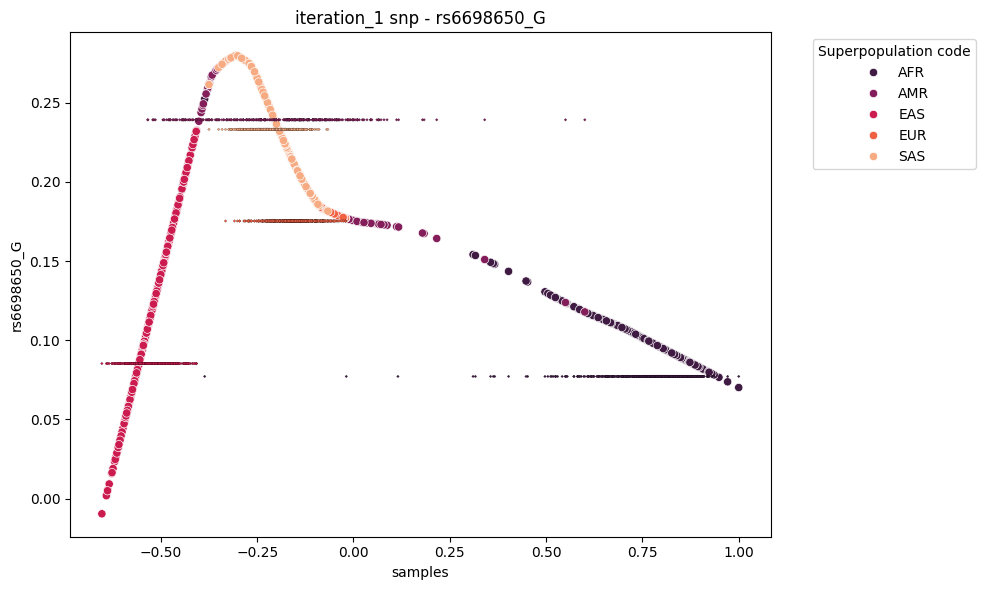

iteration_2


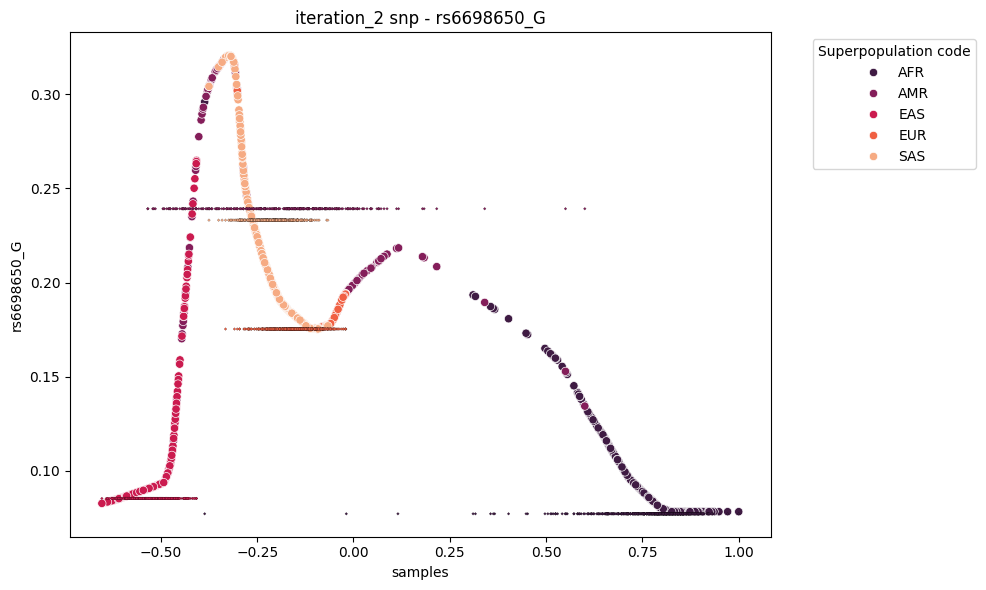

iteration_3


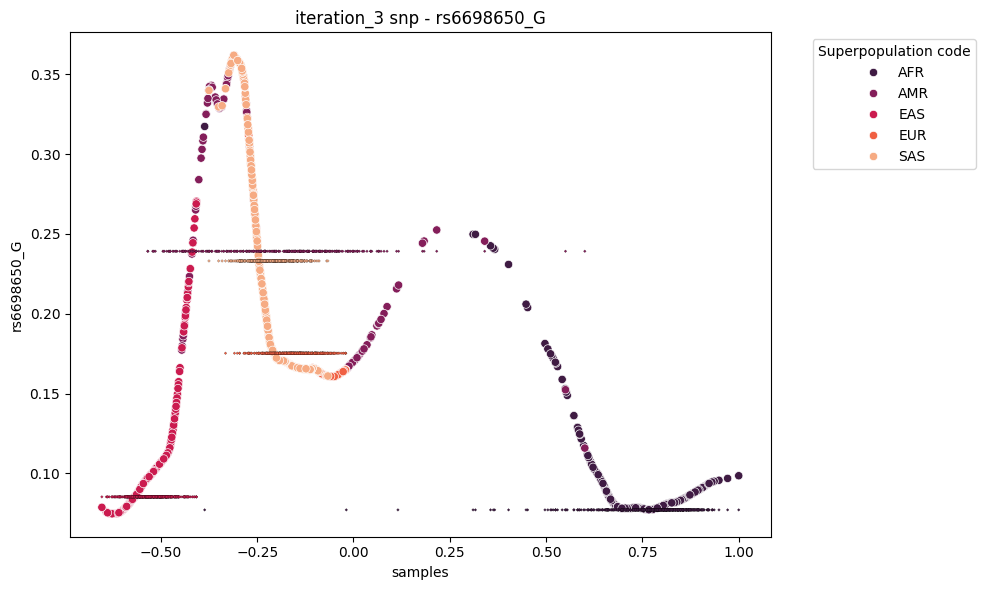

iteration_4


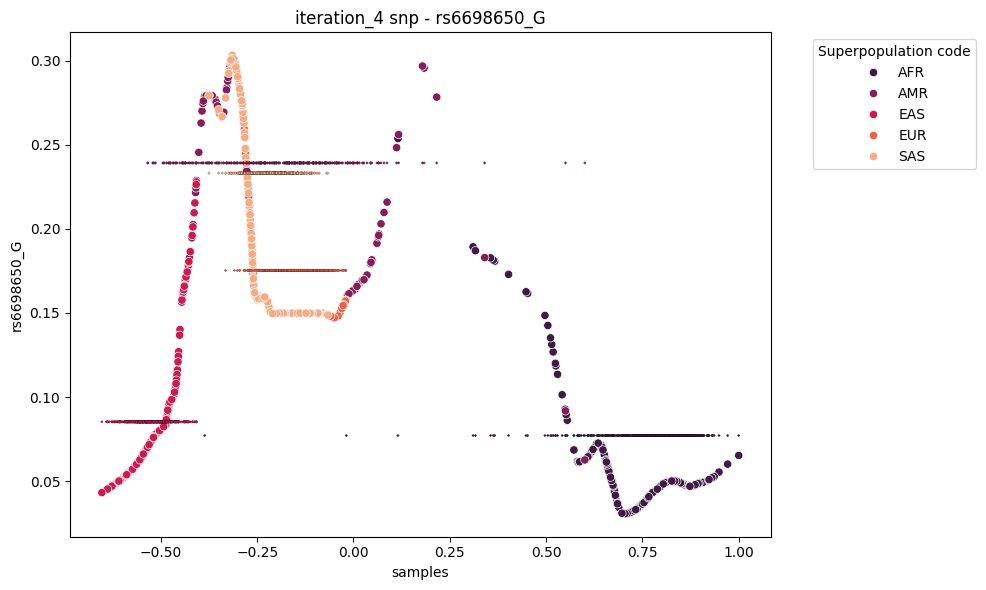

In [14]:
path_projected_snps = f"{CONFIG['PATH_data']}/04_projected/"
projections = [f for f in os.listdir(path_projected_snps) if f.startswith("projection")]
for projection in projections[0:1]:
    print(f"Running projection {projection}")
    projection_nr = int(projection.split("_")[-1])
    path_projection = f"{path_projected_snps}/{projection}/"
    
    
    central_dim  = pd.read_pickle(f"{path_projection}/iteration_1/concated_one_hot_dims.pkl")
    iterations = [f for f in os.listdir(f"{path_projection}") if f.startswith('iteration')]
    iterations.sort()
    for iteration in iterations:
        print(iteration)
        path_maf = f"{path_projection}/{iteration}/05_macro_estimated_AF/"
        for chrom in [f for f in os.listdir(path_maf) if f.startswith('chrom')][0:1]:
            path_p2 = f"{path_maf}/{chrom}/p2/"
            blocks = [f for f in os.listdir(path_p2) if f.startswith('AFs')]
            path_chrom = f"{path_maf}/{chrom}/"
            for block in blocks[0:1]:
                min_AFs = pd.read_pickle(f"{path_chrom}/q2/{block}")
                het_AFs = pd.read_pickle(f"{path_chrom}/2pq/{block}")
                maj_AFs = pd.read_pickle(f"{path_chrom}/p2/{block}")
                path_snps = f"{path_projection}/04_ld_blocks/{chrom}/{block.split('AFs_')[1]}"
                to_check = list(min_AFs.columns)[-1]
                snps = pd.read_pickle(path_snps)[[to_check]]
                snps['pop'] = list(ids['Superpopulation code'])
                
                maf_per_population = calculate_maf(snps)
                AFs = min_AFs[[to_check]].copy()
                AFs['Superpopulation code'] = list(ids['Superpopulation code'])
                AFs['Population code'] = list(ids['Population code'])
                AFs['samples'] = list(central_dim['pop_0_PC1_dim_1'])
                AFs['mafs'] = AFs['Superpopulation code'].map(maf_per_population)
                
                AFs = AFs.loc[AFs['Superpopulation code'] != 'EUR,AFR']

                plt = make_population_plot(AFs, 'samples', to_check,'Superpopulation code', f"{iteration} snp - {to_check}", palette = 'rocket')
                ax = plt.gca()  # Get the current axis

                # Overlay MAF values on top of the existing plot
                # Overlay the MAF points
                sns.scatterplot(
                    data=AFs,
                    x='samples',
                    y='mafs',
                    hue='Superpopulation code',
                    palette='rocket',  # Different palette to differentiate
                    marker='D',      # Diamond marker for visibility
                    edgecolor='black',
                    s=2,           # Adjust size for emphasis
                    ax=ax,         # Ensure overlay is on the same plot
                    legend=False 
                )

                plt.show()

# Make a global Fst

In [ ]:
path_input = "05_macro_estimated_AF"
path_output = f"/06_esti_Fst/"
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
    estimated_mafs = [f for f in os.listdir(path_iteration) if f.startswith('05_macro_estimated_AF')]
    for maf in estimated_mafs:
        path_maf = f"{path_iteration}/{maf}"
        chroms = [f for f in os.listdir(path_maf) if f.startswith('chrom')]
        for chrom in chroms:
            path_chrom = f"{path_maf}/{chrom}"
            path_output_chrom = f"{path_iteration}/{path_output}/{chrom}"
            os.makedirs(path_output_chrom, exist_ok=True)
            
            AFs = [f for f in os.listdir(f"{path_chrom}/p2") if f.startswith('AFs')]
            for file in AFs:
                make_fst(path_chrom, file, path_output_chrom)


In [ ]:
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_input= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    path_output= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    os.makedirs(path_output, exist_ok=True)
    make_global_fst(path_input, path_output)

In [ ]:
ids

,FID,IID,PAT,MAT,SEX,PHENOTYPE,index,Sample name,Sex,Population code,...,Superpopulation code,Superpopulation name,dim1_iter_1,dim2_iter_1,dim1_iter_2,dim2_iter_2,dim1_iter_3,dim2_iter_3,dim1_iter_4,dim2_iter_4
0,AFR,HG01879,0,0,1,-9,0,HG01879,male,ACB,...,AFR,African Ancestry,15.541492,-12.273438,20.828602,-17.130701,8.841963,9.691701,16.250404,2.021288
1,AFR,HG01880,0,0,2,-9,1,HG01880,female,ACB,...,AFR,African Ancestry,17.884426,4.369789,4.398439,11.814238,8.341516,8.238756,15.826401,2.893323
2,AFR,HG01882,0,0,1,-9,2,HG01882,male,ACB,...,AFR,African Ancestry,14.771043,26.521328,24.748432,-7.018355,21.069519,17.364147,24.005230,-15.742570
3,AFR,HG01883,0,0,2,-9,3,HG01883,female,ACB,...,AFR,African Ancestry,15.260288,-11.459195,21.575188,-17.447659,9.150179,10.810210,15.632032,2.600430
4,AFR,HG01885,0,0,1,-9,4,HG01885,male,ACB,...,AFR,African Ancestry,14.800077,26.435913,24.785049,-7.094584,20.967707,17.314436,23.973804,-15.754035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,SAS,NA21137,0,0,2,-9,2499,NA21137,female,GIH,...,SAS,South Asian Ancestry,-16.829222,5.668034,5.006234,-9.830592,12.060284,-5.311810,-11.152917,-3.971169
2500,SAS,NA21141,0,0,2,-9,2500,NA21141,female,GIH,...,SAS,South Asian Ancestry,-16.851557,5.999689,5.104946,-10.232482,12.553152,-1.712085,-1.115068,15.745655
2501,SAS,NA21142,0,0,2,-9,2501,NA21142,female,GIH,...,SAS,South Asian Ancestry,-16.724520,4.295968,4.899845,-8.739561,7.600638,-9.636189,-11.360074,7.427902
2502,SAS,NA21143,0,0,2,-9,2502,NA21143,female,GIH,...,SAS,South Asian Ancestry,-16.846453,6.055001,5.090753,-10.302771,12.566281,-1.597930,-1.048935,15.704002


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_population_palette(df, superpop_col, pop_col):
    """Generates a distinct color palette for populations based on superpopulations."""
    unique_superpops = df[superpop_col].unique()
    base_palette = sns.color_palette("Set2", len(unique_superpops))  # Distinct and visible colors

    superpop_colors = {sup: base_palette[i] for i, sup in enumerate(unique_superpops)}

    # Assign unique darker shades for populations
    pop_palette = {}
    for sup in unique_superpops:
        pops = df[df[superpop_col] == sup][pop_col].unique()
        shades = sns.dark_palette(superpop_colors[sup], n_colors=len(pops), reverse=False, input="rgb")
        pop_palette.update({pop: shades[i] for i, pop in enumerate(pops)})

    return pop_palette

def make_population_plot(df, X, Y, hue, superpop_col, title):
    """Creates a population scatterplot with distinct colors for each population."""
    pop_palette = get_population_palette(df, superpop_col, hue)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=X, 
        y=Y, 
        hue=hue, 
        palette=pop_palette
    )

    plt.title(title)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()




/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


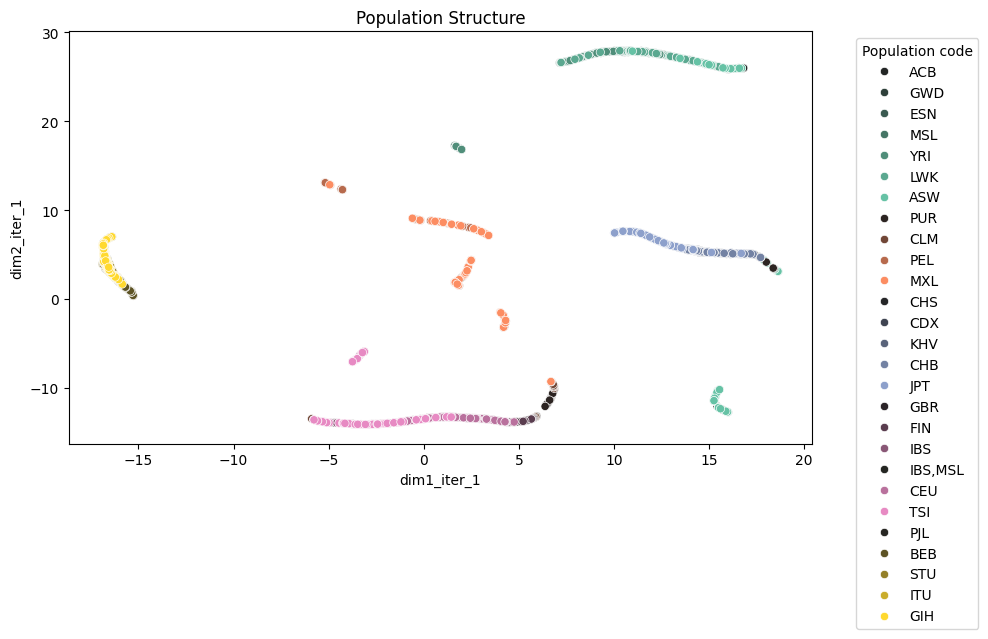

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


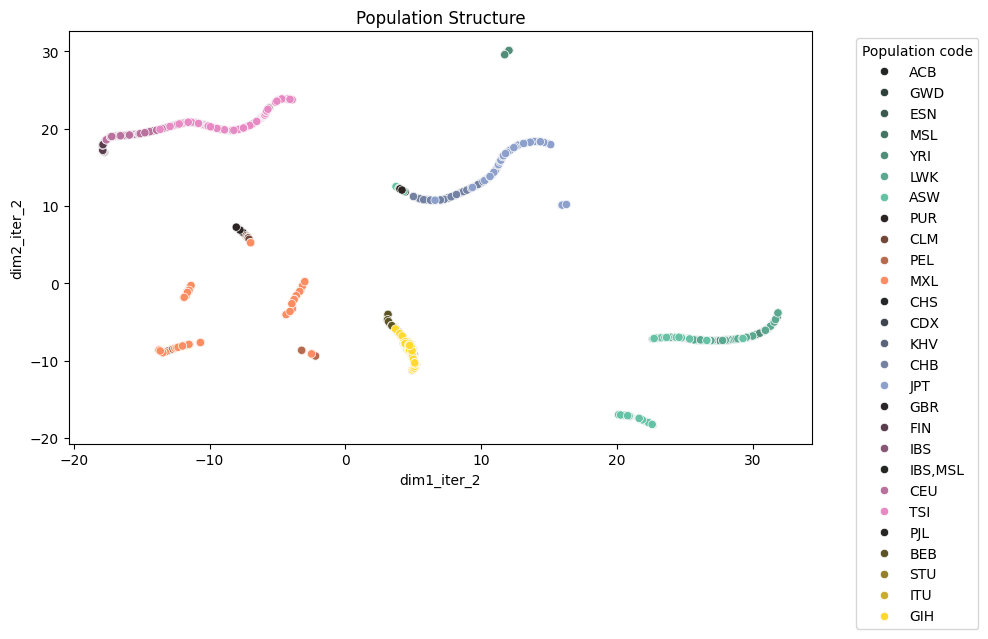

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


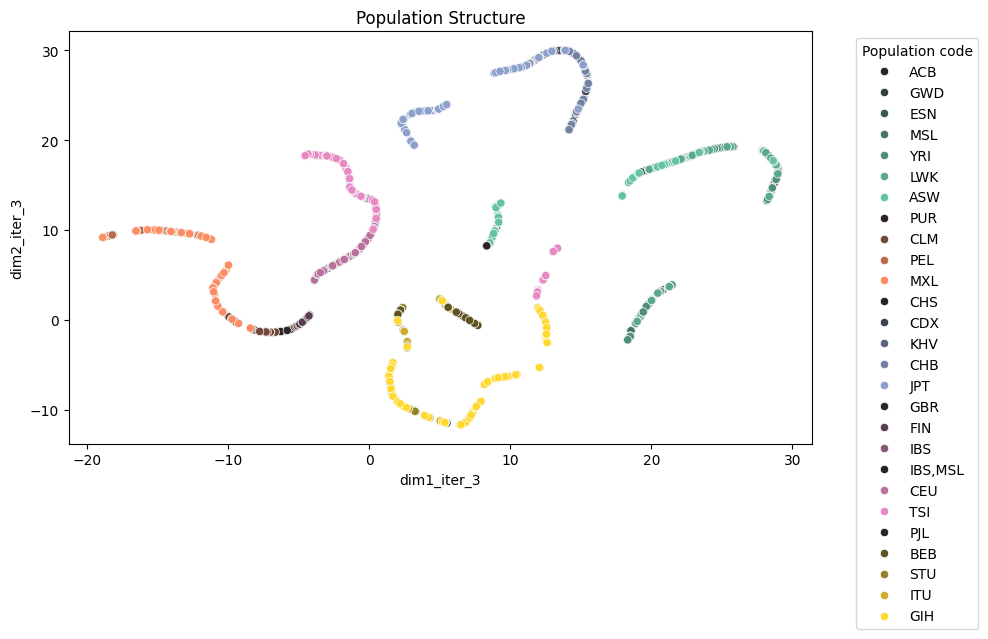

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


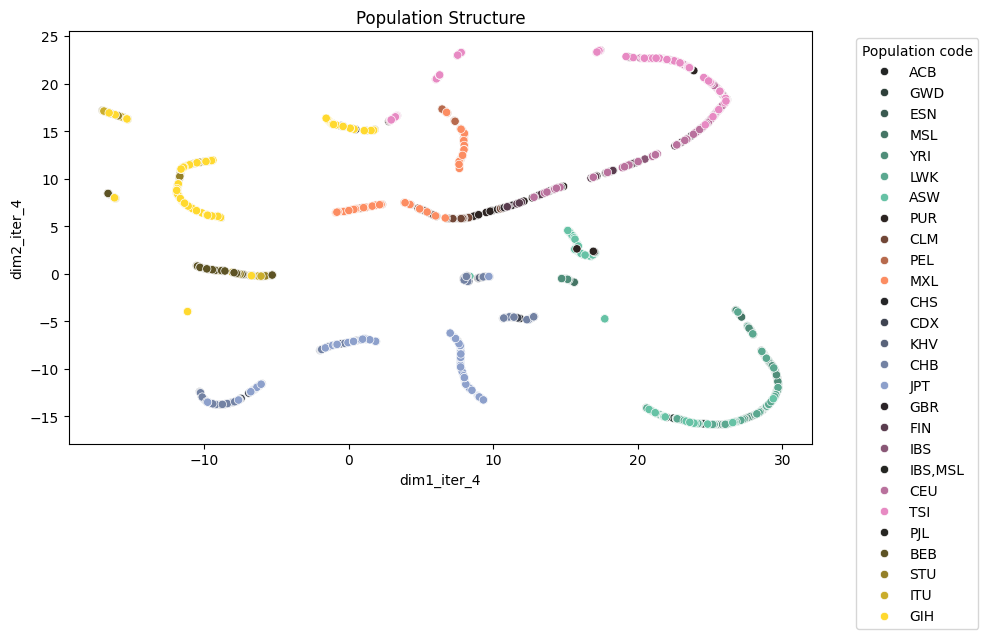

In [ ]:
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_output= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    Fst_global = pd.read_pickle(f"{path_output}/global_Fst.pkl")
    reducer = umap.UMAP(metric='precomputed', random_state=42)
    embeddings = reducer.fit_transform(Fst_global)
    ids[[f"dim1_iter_{iteration_nr}", f"dim2_iter_{iteration_nr}"]] = embeddings
    make_population_plot(ids, f"dim1_iter_{iteration_nr}", f"dim2_iter_{iteration_nr}", 'Population code', 'Superpopulation code', "Population Structure")
